In [1167]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn import preprocessing
from sklearn.svm import NuSVR
from sklearn.linear_model import SGDRegressor
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.cross_validation import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.set_option('display.max_columns', 1000)
plt.rcParams['figure.figsize'] = (17.0, 7.0)
plt.rcParams['figure.titlesize'] = 16
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams["axes.labelsize"] = 13
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12

In [1168]:
hc_details = pd.read_csv("/home/pranav/Documents/notebooks/Analytics_Vidhya/Knocktober/Train_2/Train/Health_Camp_Detail.csv")
train_data = pd.read_csv("/home/pranav/Documents/notebooks/Analytics_Vidhya/Knocktober/Train_2/Train/Train.csv")
test_data = pd.read_csv("/home/pranav/Documents/notebooks/Analytics_Vidhya/Knocktober/Test.csv")
first_hc = pd.read_csv("/home/pranav/Documents/notebooks/Analytics_Vidhya/Knocktober/Train_2/Train/First_Health_Camp_Attended.csv")
second_hc = pd.read_csv("/home/pranav/Documents/notebooks/Analytics_Vidhya/Knocktober/Train_2/Train/Second_Health_Camp_Attended.csv")
third_hc = pd.read_csv("/home/pranav/Documents/notebooks/Analytics_Vidhya/Knocktober/Train_2/Train/Third_Health_Camp_Attended.csv")
patient_profiles = pd.read_csv("/home/pranav/Documents/notebooks/Analytics_Vidhya/Knocktober/Train_2/Train/Patient_Profile.csv")

In [1169]:
hc_details['Camp_Start_Date'] = pd.to_datetime(hc_details['Camp_Start_Date'])
hc_details['Camp_End_Date'] = pd.to_datetime(hc_details['Camp_End_Date'])

In [1170]:
new_hc_details = pd.DataFrame()
for cat in hc_details.Category1.unique():
    temp = hc_details[hc_details.Category1 == cat].sort('Camp_Start_Date')
    temp['Camp_days_diff'] = temp['Camp_Start_Date'] - test['Camp_Start_Date'].shift()
    temp['Camp_days_diff'] = temp['Camp_days_diff'].astype('timedelta64[D]')
    temp = temp.fillna(0)
    new_hc_details = pd.concat([new_hc_details,temp])

/home/pranav/.local/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [1171]:
hc_details = new_hc_details

<h3> Preprocessing

<h5> Creating Outcome label for training data

In [1172]:
first_hc = first_hc[['Patient_ID','Health_Camp_ID','Health_Score']]
first_hc = first_hc.rename(columns={'Health_Score':'Outcome'})
second_hc = second_hc[['Patient_ID','Health_Camp_ID','Health Score']]
second_hc = second_hc.rename(columns={'Health Score':'Outcome'})
third_hc = third_hc[['Patient_ID','Health_Camp_ID','Number_of_stall_visited']]
third_hc = third_hc.rename(columns={'Number_of_stall_visited':'Outcome'})

hc_data = pd.concat([first_hc,second_hc,third_hc])
hc_data['Outcome'] = 1

In [1173]:
train_data = train_data.merge(hc_details,on="Health_Camp_ID")
test_data = test_data.merge(hc_details,on="Health_Camp_ID")

In [1174]:
train_data = train_data.merge(patient_profiles,on='Patient_ID')
test_data = test_data.merge(patient_profiles,on='Patient_ID')

In [1175]:
train_data = train_data.merge(hc_data[['Patient_ID','Health_Camp_ID','Outcome']],on=['Patient_ID','Health_Camp_ID'],how='left')
train_data['Outcome'] = train_data['Outcome'].fillna(0)

<h5> Calculating number of camps visited

In [1176]:
camps_visited = pd.DataFrame(train_data.groupby('Patient_ID')['Outcome'].sum())
camps_visited.columns = ['camps_visited']
camps_visited.reset_index(inplace=True)

train_data = train_data.merge(camps_visited,on='Patient_ID',how='left')
test_data = test_data.merge(camps_visited,on='Patient_ID',how='left')

<h5> time based feature generation

In [1179]:
def date_func(df):
    df['Age'] = df['Age'].map(lambda x : x if x != 'None' else np.nan)
    df['Age'] = df['Age'].apply(pd.to_numeric, errors='coerce')
    df['Registration_Date'] = pd.to_datetime(df['Registration_Date'])
    df['Camp_Start_Date'] = pd.to_datetime(df['Camp_Start_Date'])
    df['Camp_End_Date'] = pd.to_datetime(df['Camp_End_Date'])
    df['First_Interaction'] = pd.to_datetime(df['First_Interaction'])
    df['Camp_duration'] =(df['Camp_End_Date'] - df['Camp_Start_Date']).astype('timedelta64[D]')
    df['Patient_response'] =(df['Registration_Date'] - df['First_Interaction']).astype('timedelta64[D]')
    df['year'] = df['Registration_Date'].map(lambda x : x.year)
    df['month'] = df['Registration_Date'].map(lambda x : x.month)
    df['day'] = df['Registration_Date'].map(lambda x : x.day)
    df['Day_of_week'] = df['Registration_Date'].map(lambda x: x.weekday())
    df['quarter'] = df['Registration_Date'].map(lambda x: x.quarter)
    df['Weekday'] = df['Day_of_week'].map(lambda x: 0 if x<5 else 1)
    return df

<h5> label encoding categorical features

In [1180]:
le = LabelEncoder()
def categorical_to_numeric(dataset):
    for i in dataset.columns:
        #dataset[i].fillna(0,inplace=True)
        if dataset[i].dtype == "object":
            le.fit(dataset[i])
            dataset[i] = le.transform(dataset[i])
    return dataset

In [1181]:
train_data = date_func(train_data)
test_data = date_func(test_data)
orig_train = train_data
orig_test = test_data
train_data = categorical_to_numeric(train_data)
test_data = categorical_to_numeric(test_data)

<h5>Indexing cronologicall order of camp visit for each patient

In [ ]:
def visit_rank(df):
    new_df = pd.DataFrame()
    for patient in df.Patient_ID.unique():
        temp = df[df.Patient_ID == patient].sort('Registration_Date').reset_index().drop('index',axis=1).reset_index()
        new_df = pd.concat([new_df,temp])
    return new_df
train_data = visit_rank(train_data)
test_data = visit_rank(test_data)

<h5> One-hot encoding for Categor1 feature

In [ ]:
one_hot = pd.get_dummies(train_data['Category1'],columns=['Patient_ID'])
one_hot.columns = ['Cat1','Cat2','Cat3']
train_data = train_data.join(one_hot)
one_hot_test = pd.get_dummies(test_data['Category1'])
one_hot_test.columns = ['Cat1','Cat2','Cat3']
test_data = test_data.join(one_hot_test)

<h3> EDA

In [1233]:
train_data.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3,Camp_days_diff,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category,Outcome,camps_visited,Camp_duration,Patient_response,year,month,day,Day_of_week,quarter,Weekday,Cat1,Cat2,Cat3
0,489652,6578,2005-09-10,4,0,0,0,2,2005-08-16,2005-10-14,2,6,2,0.0,0,0,0,0,7,227,NaN,2004-12-06,0,0,1.0,2.0,59.0,278.0,2005.0,9.0,10.0,5.0,3.0,1,0.0,0.0,1.0
1,489652,6570,2005-05-01,0,0,0,0,0,2005-07-09,2005-07-22,0,4,2,20.0,0,0,0,0,7,227,NaN,2004-12-06,0,0,0.0,2.0,13.0,146.0,2005.0,5.0,1.0,6.0,2.0,1,1.0,0.0,0.0
2,489652,6527,2005-05-08,0,0,0,0,0,2005-06-13,2005-07-22,2,6,2,0.0,0,0,0,0,7,227,NaN,2004-12-06,0,0,1.0,2.0,39.0,153.0,2005.0,5.0,8.0,6.0,2.0,1,0.0,0.0,1.0
3,489652,6539,2004-12-06,0,0,0,0,0,2004-08-07,2005-02-12,0,5,2,78.0,0,0,0,0,7,227,NaN,2004-12-06,0,0,0.0,2.0,189.0,0.0,2004.0,12.0,6.0,0.0,4.0,0,1.0,0.0,0.0
4,489652,6543,2005-11-26,4,0,0,0,2,2005-09-27,2007-11-07,0,5,2,56.0,0,0,0,0,7,227,NaN,2004-12-06,0,0,0.0,2.0,771.0,355.0,2005.0,11.0,26.0,5.0,4.0,1,1.0,0.0,0.0


In [1235]:
test_data.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5,Camp_Start_Date,Camp_End_Date,Category1,Category2,Category3,Camp_days_diff,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Income,Education_Score,Age,First_Interaction,City_Type,Employer_Category,camps_visited,Camp_duration,Patient_response,year,month,day,Day_of_week,quarter,Weekday,Cat1,Cat2,Cat3
0,505701,6548,2006-05-21,1,0,0,0,2,2006-06-13,2006-08-18,2,5,2,0.0,0,0,0,0,0,91,44.0,2003-02-05,5,0,5.0,66.0,1201.0,2006,5,21,6,2,1,0.0,0.0,1.0
1,505701,6582,2006-04-06,1,0,0,0,2,2006-04-06,2007-11-07,0,4,2,4.0,0,0,0,0,0,91,44.0,2003-02-05,5,0,5.0,580.0,1156.0,2006,4,6,3,2,0,1.0,0.0,0.0
2,505701,6567,2007-01-04,1,0,0,0,2,2007-01-30,2007-02-04,1,2,2,0.0,0,0,0,0,0,91,44.0,2003-02-05,5,0,5.0,5.0,1429.0,2007,1,4,3,1,0,0.0,1.0,0.0
3,505701,6566,2006-02-15,1,0,0,0,2,2006-04-18,2006-04-25,0,3,2,10.0,0,0,0,0,0,91,44.0,2003-02-05,5,0,5.0,7.0,1106.0,2006,2,15,2,1,0,1.0,0.0,0.0
4,505701,6556,2006-09-09,1,0,0,0,2,2006-11-09,2006-12-15,0,3,2,48.0,0,0,0,0,0,91,44.0,2003-02-05,5,0,5.0,36.0,1312.0,2006,9,9,5,3,1,1.0,0.0,0.0


In [492]:
def missing_data(df):
    for col in df.columns:
        print col
        print "Amount of missing data : "+str(((len(df) - len(df[col].dropna()))/float(len(df)))*100.0) + "% \n"

In [493]:
missing_data(train_data)

Patient_ID
Amount of missing data : 0.0% 

Health_Camp_ID
Amount of missing data : 0.0% 

Registration_Date
Amount of missing data : 0.443688727118% 

Var1
Amount of missing data : 0.0% 

Var2
Amount of missing data : 0.0% 

Var3
Amount of missing data : 0.0% 

Var4
Amount of missing data : 0.0% 

Var5
Amount of missing data : 0.0% 

Camp_Start_Date
Amount of missing data : 0.0% 

Camp_End_Date
Amount of missing data : 0.0% 

Category1
Amount of missing data : 0.0% 

Category2
Amount of missing data : 0.0% 

Category3
Amount of missing data : 0.0% 

Online_Follower
Amount of missing data : 0.0% 

LinkedIn_Shared
Amount of missing data : 0.0% 

Twitter_Shared
Amount of missing data : 0.0% 

Facebook_Shared
Amount of missing data : 0.0% 

Income
Amount of missing data : 0.0% 

Education_Score
Amount of missing data : 0.0% 

Age
Amount of missing data : 68.561864024% 

First_Interaction
Amount of missing data : 0.0% 

City_Type
Amount of missing data : 44.1138181142% 

Employer_Category
A

In [466]:
missing_data(test_data)

Patient_ID
Amount of missing data : 0.0% 

Health_Camp_ID
Amount of missing data : 0.0% 

Registration_Date
Amount of missing data : 0.0% 

Var1
Amount of missing data : 0.0% 

Var2
Amount of missing data : 0.0% 

Var3
Amount of missing data : 0.0% 

Var4
Amount of missing data : 0.0% 

Var5
Amount of missing data : 0.0% 

Camp_Start_Date
Amount of missing data : 0.0% 

Camp_End_Date
Amount of missing data : 0.0% 

Category1
Amount of missing data : 0.0% 

Category2
Amount of missing data : 0.0% 

Category3
Amount of missing data : 0.0% 

Online_Follower
Amount of missing data : 0.0% 

LinkedIn_Shared
Amount of missing data : 0.0% 

Twitter_Shared
Amount of missing data : 0.0% 

Facebook_Shared
Amount of missing data : 0.0% 

Income
Amount of missing data : 0.0% 

Education_Score
Amount of missing data : 0.0% 

Age
Amount of missing data : 74.6489262107% 

First_Interaction
Amount of missing data : 0.0% 

City_Type
Amount of missing data : 0.0% 

Employer_Category
Amount of missing dat

In [ ]:
train_data

In [403]:
test_data.describe()

,Patient_ID,Health_Camp_ID,Var1,Var2,Var3,Var4,Var5,Category3,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Age,Camp_duration,Patient_response,year,month,day,Day_of_week,quarter,Weekday
count,35249.000000,35249.000000,35249.000000,35249.000000,35249.000000,35249.000000,35249.000000,35249.0,35249.000000,35249.000000,35249.000000,35249.000000,8936.000000,35249.000000,35249.000000,35249.000000,35249.000000,35249.000000,35249.000000,35249.000000,35249.000000
mean,507020.926863,6568.160373,0.819201,0.253312,0.000567,0.041845,0.258163,2.0,0.052087,0.058526,0.047774,0.050356,49.010407,107.290987,360.323130,2006.083151,7.024682,16.434963,3.024171,2.663139,0.286618
std,12478.669016,13.212263,8.298817,3.984690,0.023814,0.268826,1.311230,0.0,0.222205,0.234740,0.213292,0.218682,12.964244,179.934112,397.182283,0.276115,3.002753,8.423599,2.007401,0.950579,0.452188
min,485678.000000,6525.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,0.000000,0.000000,0.000000,0.000000,30.000000,3.000000,0.000000,2006.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,496203.000000,6556.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,0.000000,0.000000,0.000000,0.000000,NaN,5.000000,10.000000,2006.000000,5.000000,10.000000,1.000000,2.000000,0.000000
50%,507018.000000,6568.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,0.000000,0.000000,0.000000,0.000000,NaN,9.000000,207.000000,2006.000000,7.000000,17.000000,3.000000,3.000000,0.000000
75%,517869.000000,6582.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,0.000000,0.000000,0.000000,0.000000,NaN,98.000000,612.000000,2006.000000,9.000000,23.000000,5.000000,3.000000,1.000000
max,528657.000000,6584.000000,344.000000,181.000000,1.000000,8.000000,34.000000,2.0,1.000000,1.000000,1.000000,1.000000,78.000000,580.000000,1543.000000,2007.000000,12.000000,31.000000,6.000000,4.000000,1.000000


In [404]:
train_data.describe()

,Patient_ID,Health_Camp_ID,Var1,Var2,Var3,Var4,Var5,Category3,Online_Follower,LinkedIn_Shared,Twitter_Shared,Facebook_Shared,Age,Outcome,Camp_duration,Patient_response,year,month,day,Day_of_week,quarter,Weekday
count,75278.000000,75278.000000,75278.000000,75278.000000,75278.000000,75278.000000,75278.000000,75278.000000,75278.000000,75278.000000,75278.000000,75278.000000,23666.000000,75278.000000,75278.000000,74944.000000,74944.000000,74944.000000,74944.000000,74944.000000,74944.000000,75278.000000
mean,507233.325660,6547.597319,0.796156,0.238556,0.000385,0.022424,0.248386,1.994593,0.055660,0.065756,0.053030,0.055607,47.906068,0.273015,208.951274,196.812660,2004.899365,6.549464,15.697040,3.076577,2.497985,0.313491
std,12404.734886,19.272983,7.626687,3.769594,0.019624,0.199570,1.213938,0.073331,0.229266,0.247857,0.224095,0.229163,11.556949,0.445511,283.242511,271.180607,0.815671,3.544424,8.944001,2.000319,1.147419,0.463915
min,485679.000000,6523.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,31.000000,0.000000,2.000000,0.000000,2003.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,496505.250000,6534.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,13.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,507276.500000,6541.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,48.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,517919.000000,6562.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,205.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
max,528657.000000,6587.000000,288.000000,156.000000,1.000000,4.000000,31.000000,2.000000,1.000000,1.000000,1.000000,1.000000,80.000000,1.000000,771.000000,1543.000000,2007.000000,12.000000,31.000000,6.000000,4.000000,1.000000


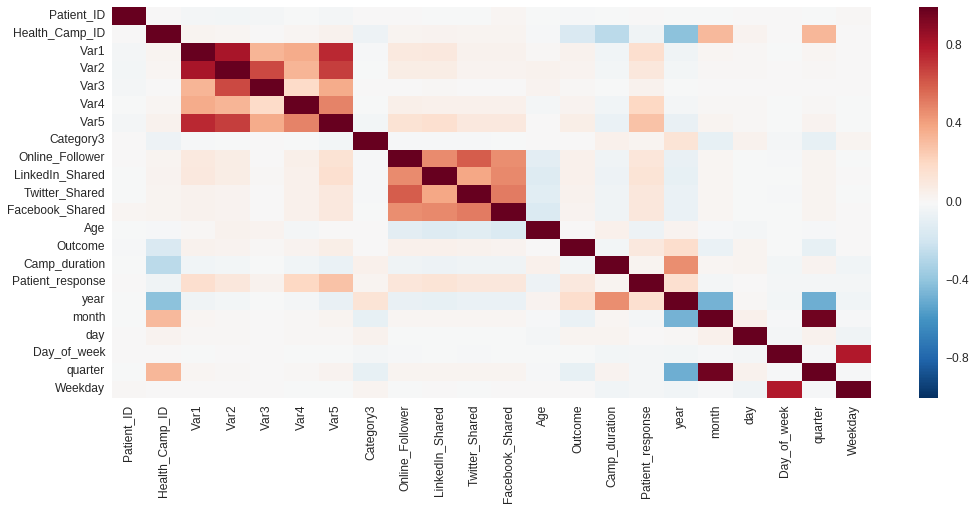

In [405]:
sns.heatmap(train_data.corr())

In [1043]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75278 entries, 0 to 75277
Data columns (total 33 columns):
Patient_ID           75278 non-null int64
Health_Camp_ID       75278 non-null int64
Registration_Date    74944 non-null datetime64[ns]
Var1                 75278 non-null int64
Var2                 75278 non-null int64
Var3                 75278 non-null int64
Var4                 75278 non-null int64
Var5                 75278 non-null int64
Camp_Start_Date      75278 non-null datetime64[ns]
Camp_End_Date        75278 non-null datetime64[ns]
Category1            75278 non-null int64
Category2            75278 non-null int64
Category3            75278 non-null int64
Online_Follower      75278 non-null int64
LinkedIn_Shared      75278 non-null int64
Twitter_Shared       75278 non-null int64
Facebook_Shared      75278 non-null int64
Income               75278 non-null int64
Education_Score      75278 non-null int64
Age                  23666 non-null float64
First_Interaction    7

<h3> Data preperation

In [1224]:
cols = ['Var1','Var2','Var3','Var4','month','Camp_duration','Category2','Category1','Category3','City_Type',
       'Employer_Category']
drop_cols = ['Patient_ID','Health_Camp_ID','Registration_Date','Camp_Start_Date',
                             'Camp_End_Date','First_Interaction']
#data_train = train_data.drop(drop_cols,axis=1).fillna(-1)
#data_train = data_train.drop('Outcome',axis=1)
#data_test = test_data.drop(drop_cols,axis=1).fillna(-1)
data_train = train_data[cols].fillna(0)
data_test = test_data[cols].fillna(0)
label = train_data['Outcome']

<h3> Gradient Boosting

In [1101]:
est = GradientBoostingClassifier(n_estimators=300, learning_rate=0.4)
scores = cross_val_score(est, data_train, label, cv=5)

In [1102]:
print cols
scores

['Var1', 'Var2', 'Var3', 'Var4', 'month', 'Camp_duration', 'Category2', 'Category1', 'Category3', 'City_Type', 'Employer_Category', 'index']


array([ 0.729561  ,  0.71174283,  0.7479907 ,  0.75582863,  0.81188974])

In [549]:
print cols
scores

['Var1', 'Var2', 'Var3', 'Var4', 'month', 'Camp_duration']


array([ 0.7546656 ,  0.7141339 ,  0.75177682,  0.75728994,  0.83633344])

In [1103]:
est = GradientBoostingClassifier(n_estimators=300, learning_rate=0.4).fit(data_train, label)
prediction_df['Outcome'] = est.predict_proba(data_test)
prediction_df.to_csv("/home/pranav/Documents/notebooks/Analytics_Vidhya/Knocktober/Submission.csv",index=False)

/home/pranav/.local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [695]:
est.feature_importances_

array([ 0.27747707,  0.1390975 ,  0.        ,  0.04483099,  0.25644011,
        0.2301528 ,  0.05200153])

<h3> XGBoost

In [1225]:
dTrain = xgb.DMatrix(data_train,label=label)
dTest = xgb.DMatrix(data_test)

In [1229]:
param = {'booster':'gbtree','objective':'reg:logistic'}
param['eta'] = 0.1
param['eval_metric'] = 'auc'
#param['gamma'] = 5
param['max_depth'] = 4
#param['min_child_weight'] = 2
#param['max_delta_step'] = 2
#param['lambda'] = 2
param['tree_method'] = 'exact'
param['scale_pos_weight'] = .06
watchlist  = [(dTrain,'train')]
#num_round = 150
early_stopping_rounds=30

In [1230]:
prediction_df = test_data[['Patient_ID','Health_Camp_ID']]

In [1231]:
xgb_model = xgb.train(param,dTrain,early_stopping_rounds,watchlist)
prediction_df['Outcome'] = xgb_model.predict(dTest)
prediction_df.to_csv("/home/pranav/Documents/notebooks/Analytics_Vidhya/Knocktober/Submission.csv",index=False)

[0]	train-auc:0.770464
[1]	train-auc:0.770942
[2]	train-auc:0.792999
[3]	train-auc:0.793544
[4]	train-auc:0.79407
[5]	train-auc:0.793763
[6]	train-auc:0.794078
[7]	train-auc:0.794068
[8]	train-auc:0.802507
[9]	train-auc:0.802495
[10]	train-auc:0.804783
[11]	train-auc:0.804786
[12]	train-auc:0.804778
[13]	train-auc:0.805028
[14]	train-auc:0.81328
[15]	train-auc:0.814103
[16]	train-auc:0.814066
[17]	train-auc:0.814273
[18]	train-auc:0.814437
[19]	train-auc:0.814421
[20]	train-auc:0.815453
[21]	train-auc:0.816513
[22]	train-auc:0.817239
[23]	train-auc:0.817402
[24]	train-auc:0.817422
[25]	train-auc:0.817547
[26]	train-auc:0.817687
[27]	train-auc:0.81765
[28]	train-auc:0.817762
[29]	train-auc:0.817955


/home/pranav/.local/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [933]:
xgb.cv(param, dTrain, early_stopping_rounds, nfold=10,
       metrics={'auc'}, seed = 0,
       callbacks=[xgb.callback.print_evaluation(show_stdv=True)])

[0]	train-auc:0.801109+0.000550395	test-auc:0.800921+0.00479275
[1]	train-auc:0.801802+0.0006564	test-auc:0.801249+0.00480986
[2]	train-auc:0.802377+0.000827388	test-auc:0.801937+0.00467642
[3]	train-auc:0.803178+0.000901653	test-auc:0.802665+0.00443529
[4]	train-auc:0.803469+0.000702886	test-auc:0.802892+0.00468614
[5]	train-auc:0.805277+0.00101566	test-auc:0.80464+0.00477799
[6]	train-auc:0.808853+0.0035205	test-auc:0.807478+0.00650747
[7]	train-auc:0.813655+0.000610582	test-auc:0.812972+0.00449132
[8]	train-auc:0.815141+0.000825012	test-auc:0.814349+0.00442182
[9]	train-auc:0.816007+0.000530322	test-auc:0.815355+0.00425313
[10]	train-auc:0.816229+0.000376459	test-auc:0.815484+0.00436886
[11]	train-auc:0.81635+0.000457856	test-auc:0.815616+0.00433949
[12]	train-auc:0.816583+0.000382023	test-auc:0.815962+0.00423657
[13]	train-auc:0.816711+0.000414859	test-auc:0.816051+0.00419681
[14]	train-auc:0.81691+0.000617806	test-auc:0.816186+0.00412775
[15]	train-auc:0.817322+0.000527374	test-au

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.800921,0.004793,0.801109,0.000550
1,0.801249,0.004810,0.801802,0.000656
2,0.801937,0.004676,0.802377,0.000827
3,0.802665,0.004435,0.803178,0.000902
4,0.802892,0.004686,0.803469,0.000703
5,0.804640,0.004778,0.805277,0.001016
6,0.807478,0.006507,0.808853,0.003521
7,0.812972,0.004491,0.813655,0.000611
8,0.814349,0.004422,0.815141,0.000825
9,0.815355,0.004253,0.816007,0.000530
